# Project C - Wavelets

In [1]:
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools.projectC as im

# Q1 - Q3

See imagetools/projectC.py

Code is provided here for convenience

```
class Identity(LinearOperator):
    def __init__(self, shape):
        ishape = oshape = shape
        LinearOperator.__init__(self, ishape, oshape)
        
    def __call__(self, x):
        return x
    
    def adjoint(self, x):
        # note that the adjoint of the identity matrix is the identity matrix itself.
        # it is easy to see this by the definition of a linear operator, noting the commutative property of the inner product    
        return self.__call__(x)

    def gram(self, x):
        # apply the gram matrix to x, which is equivalent to just returning x
        return x
    
    def gram_resolvent(self, x, tau):
        # do the inversion by the conjugate gradient
        return cg(lambda z: z + tau * self.gram(z), x)
    
class Convolution(LinearOperator):
    def __init__(self, shape, nu, separable=None):
        ishape = oshape = shape
        LinearOperator.__init__(self, ishape, oshape)

        self._separable = separable
        n1, n2 = ishape[:2]
        self._nu_fft = kernel2fft(nu, n1, n2, separable=self._separable)
        # mu = F^{-1}(conjugate(F(nu))), see assignment 5 for explanation
        self._mu_fft = np.conjugate(self._nu_fft)
        
    def __call__(self, x):
        return convolvefft(x,self._nu_fft)
    
    def adjoint(self, x):
        return convolvefft(x, self._mu_fft)
    
    def gram(self, x):
        # self.adjoint(self.__call__(x),x), reduced to convolvefft(x, nu_fft*mu_fft) by properties of fft
        return convolvefft(x, nu_fft*mu_fft)
    
    def gram_resolvent(self, x, tau):
        # Assuming that boundary is always periodical
        # Just like the Gram LinearOperator, can do the inversion in the Fourier domain when periodical
        res_nu = 1 / (1 - tau * self._conv_nu)
        return convolvefft(x, res_nu)
    
class RandomMasking(LinearOperator):
    def __init__(self, shape, p):
        ishape = oshape = shape
        LinearOperator.__init__(self, ishape, oshape)
        
        self._apply_random_mask = np.random.choice(np.array([0,1]), size=oshape, p=[p,1-p])
        
    def __call__(self, x):
        # apply pixel by pixel the random mask
        return self._apply_random_mask * x
    
    def adjoint(self, x):
        # easy to see this is self-adjoint by the definition of a linear operator, noting the commutative property of the inner product 
        return self.__call__(x)

    def gram(self, x):
        # self.adjoint(self.__call__(x),x), reduced to below because 0*0 =0, 1*0 =0, 0*1=0,1*1=1
        return self._apply_random_mask * x
    
    def gram_resolvent(self, x, tau):
        return cg(lambda z: z + tau * self.gram(z), x)
 
```

# Q4

In [2]:
starfish = plt.imread('assets/starfish.png')
x0 = starfish
motion_kernel = im.kernel('motion')

In [3]:
H_identity = im.Identity(x0.shape)
H_convolution = im.Convolution(x0.shape,nu=motion_kernel)
H_random_masking = im.RandomMasking(x0.shape,p=0.4)

In [4]:
y1, y2, y3 = H_identity(x0), H_convolution(x0), H_random_masking(x0)

images for Q4


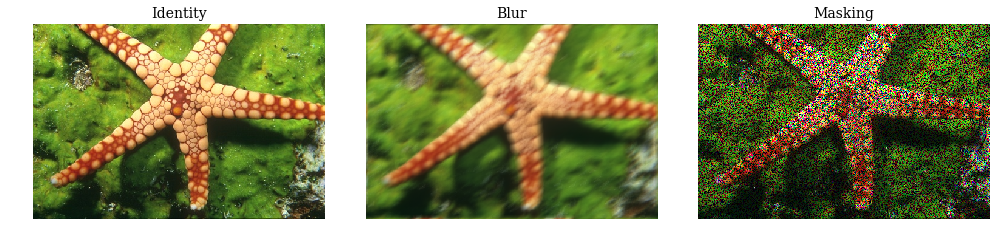

In [15]:
fig,ax = plt.subplots(1, 3,figsize=(14,6))
im.show(y1,ax=ax[0])
ax[0].tick_params(axis='both', which='major', labelsize=10)
ax[0].set_title('Identity',fontdict = {'fontsize' : 14})
im.show(y2,ax=ax[1])
ax[1].tick_params(axis='both', which='major', labelsize=10)
ax[1].set_title('Blur',fontdict = {'fontsize' : 14})
im.show(y3,ax=ax[2])
ax[2].tick_params(axis='both', which='major', labelsize=10)
ax[2].set_title('Masking',fontdict = {'fontsize' : 14})
print('images for Q4')

# Q5 assert that〈Hx, y〉=〈x,H∗y〉for any arbitrary arrays x and y of shape H.ishape and H.oshape respectively 

In [43]:
def dot_product(A,B):
    return np.sum(A*B)

def assert_adjoint(x,y,H):
    result = np.isclose(dot_product(H(x),y),dot_product(x,H.adjoint(y)))
    assert result
    return result

In [64]:
def test_dotproduct_adjoint(totest):
    if totest is 'Identity':
        operator = im.Identity
    elif totest is 'Convolution':
        operator = im.Convolution
    elif totest is 'RandomMasking':
        operator = im.RandomMasking
    # get some random ints between 1 and 4
    a,b,c,d = np.random.randint(1,high=4,size=4)
    
    # check for 1D
    if totest is 'Identity':
        H = operator(a)
    elif totest is 'Convolution':
        H = operator(a,nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator(a,p=0.4)
    x = np.random.rand(H.ishape)
    y = np.random.rand(H.oshape)
    print('1 dimensional case (int) - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H_identity))

    # check corner case for 1D
    if totest is 'Identity':
        H = operator((a,))
    elif totest is 'Convolution':
        H = operator((a,),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,),p=0.4)
    x = np.random.rand(*H.ishape)
    y = np.random.rand(*H.oshape)
    print('1 dimensional case (tuple) - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H_identity))

    # check 2D
    if totest is 'Identity':
        H = operator((a,b))
    elif totest is 'Convolution':
        H = operator((a,b),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b),p=0.4)
    x = np.random.rand(*H.ishape)
    y = np.random.rand(*H.oshape)
    print('2 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H_identity))

    # check 3D
    if totest is 'Identity':
        H = operator((a,b,c))
    elif totest is 'Convolution':
        H = operator((a,b,c),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b,c),p=0.4)
    H = operator((a,b,c))
    x = np.random.rand(*H.ishape)
    y = np.random.rand(*H.oshape)
    print('3 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H_identity))

    # check 4D
    if totest is 'Identity':
        H = operator((a,b,c,d))
    elif totest is 'Convolution':
        H = operator((a,b,c,d),nu=motion_kernel)
    elif totest is 'RandomMasking':
        H = operator((a,b,c,d),p=0.4)
    x = np.random.rand(*H.ishape)
    y = np.random.rand(*H.oshape)
    print('4 dimensional case - input shape is: ',x.shape, 'is does {} test'.format(totest),'hold? ',assert_adjoint(x,y,H_identity))
    
    # after 4D we can assume it generalizes

In [65]:
test_dotproduct_adjoint('Identity')

1 dimensional case (int) - input shape is:  (1,) is does Identity test hold?  True
1 dimensional case (tuple) - input shape is:  (1,) is does Identity test hold?  True
2 dimensional case - input shape is:  (1, 3) is does Identity test hold?  True
3 dimensional case - input shape is:  (1, 3, 3) is does Identity test hold?  True
4 dimensional case - input shape is:  (1, 3, 3, 2) is does Identity test hold?  True


In [66]:
test_dotproduct_adjoint('Convolution')

IndexError: invalid index to scalar variable.

In [67]:
test_dotproduct_adjoint('RandomMasking')

1 dimensional case (int) - input shape is:  (1,) is does RandomMasking test hold?  True
1 dimensional case (tuple) - input shape is:  (1,) is does RandomMasking test hold?  True
2 dimensional case - input shape is:  (1, 3) is does RandomMasking test hold?  True


TypeError: __init__() missing 1 required positional argument: 'p'

# Q6.  Check also that Inverse(Id +τH∗H) (x+τH∗Hx) = x for any arbitrary image x of shape H.ishape.